In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from dataclasses import dataclass

In [2]:


class DriftDiffusionModel:
    """
    A class that implements the drift-diffusion model for perceptual decision making
    as described in the 2AFC-task.

    The model is described by the stochastic differential equation:
    dx(t)/dt = (IA - IB) + σ*η(t)

    where:
    - x is the decision variable
    - IA and IB are the decision inputs
    - η(t) is a noise term (Gaussian white noise with unit standard deviation)
    - σ is the noise magnitude
    """

    def __init__(self, 
                input_A: float = 0.95, 
                input_B: float = 1.0, 
                noise_magnitude: float = 7.0,
                threshold: float = 20.0,
                dt: float = 0.1):
        """
        Initialize the drift-diffusion model with the given parameters.

        Parameters:
        -----------
        input_A : float
            The input for decision A (IA)
        input_B : float
            The input for decision B (IB)
        noise_magnitude : float
            The magnitude of the noise (σ)
        threshold : float
            The decision threshold (µ)
        dt : float
            The time step for numerical simulation
        """
        self.input_A = input_A
        self.input_B = input_B
        self.noise_magnitude = noise_magnitude
        self.threshold = threshold
        self.dt = dt
        
    def drift_term(self) -> float:
        """Calculate the drift term (IA - IB)"""
        return self.input_A - self.input_B
    
    def noise_term(self) -> float:
        """Generate a noise term σ*η(t)"""
        # Gaussian white noise with appropriate scaling for the time step
        return self.noise_magnitude * np.random.normal(0, 1) * np.sqrt(self.dt)
    
    def simulate_single_trial(self, 
                            initial_x: float = 0.0, 
                            max_steps: int = 10000) -> Tuple[np.ndarray, np.ndarray, str]:
        """
        Simulate a single trial of the drift-diffusion process.
        
        Parameters:
        -----------
        initial_x : float
            The initial value of the decision variable x
        max_steps : int
            The maximum number of simulation steps
            
        Returns:
        --------
        Tuple[np.ndarray, np.ndarray, str]
            - The array of time points
            - The array of decision variable values
            - The outcome ('A', 'B', or 'None')
        """
        # Initialize arrays to store results
        time_points = np.arange(0, max_steps * self.dt, self.dt)
        x_values = np.zeros(max_steps)
        x_values[0] = initial_x
        
        # Run simulation
        for i in range(1, max_steps):
            # Update x using the stochastic differential equation
            dx = self.drift_term() * self.dt + self.noise_term()
            x_values[i] = x_values[i-1] + dx
            
            # Check if a decision threshold has been reached
            if x_values[i] >= self.threshold:
                # Decision A
                return time_points[:i+1], x_values[:i+1], 'A'
            elif x_values[i] <= -self.threshold:
                # Decision B
                return time_points[:i+1], x_values[:i+1], 'B'
        
        # If no decision was reached within max_steps
        return time_points, x_values, 'None'
    
    def simulate_multiple_trials(self, 
                               num_trials: int, 
                               initial_x: float = 0.0, 
                               max_steps: int = 10000) -> List[Tuple[np.ndarray, np.ndarray, str]]:
        """
        Simulate multiple trials of the drift-diffusion process.
        
        Parameters:
        -----------
        num_trials : int
            The number of trials to simulate
        initial_x : float
            The initial value of the decision variable x
        max_steps : int
            The maximum number of simulation steps
            
        Returns:
        --------
        List[Tuple[np.ndarray, np.ndarray, str]]
            A list containing the results of each trial
        """
        results = []
        for _ in range(num_trials):
            results.append(self.simulate_single_trial(initial_x, max_steps))
        return results
    
    def count_outcomes(self, trial_results: List[Tuple[np.ndarray, np.ndarray, str]]) -> dict:
        """
        Count the different outcomes from a set of trial results.
        
        Parameters:
        -----------
        trial_results : List[Tuple[np.ndarray, np.ndarray, str]]
            The results from multiple trials
            
        Returns:
        --------
        dict
            A dictionary containing the counts of each outcome
        """
        outcomes = {'A': 0, 'B': 0, 'None': 0}
        for _, _, outcome in trial_results:
            outcomes[outcome] += 1
        return outcomes
    
    def get_reaction_times(self, trial_results: List[Tuple[np.ndarray, np.ndarray, str]]) -> dict:
        """
        Get the reaction times for different outcomes.
        
        Parameters:
        -----------
        trial_results : List[Tuple[np.ndarray, np.ndarray, str]]
            The results from multiple trials
            
        Returns:
        --------
        dict
            A dictionary containing lists of reaction times for each outcome type
        """
        reaction_times = {'A': [], 'B': [], 'None': []}
        for time_points, _, outcome in trial_results:
            if outcome != 'None':
                reaction_times[outcome].append(time_points[-1])
        return reaction_times
    

def plot_single_trials(trial_results: List[Tuple[np.ndarray, np.ndarray, str]], title: str = "Multiple Trials", save_path: str = None):
    """
    Plot the decision variable trajectories for multiple trials.
    
    Parameters:
    -----------
    trial_results : List[Tuple[np.ndarray, np.ndarray, str]]
        The results from multiple trials
    title : str
        The title for the plot
    save_path : str
        If provided, save the figure to this path
    """
    plt.figure(figsize=(12, 8))
    
    for i, (time_points, x_values, outcome) in enumerate(trial_results):
        if outcome == 'A':
            plt.plot(time_points, x_values, label=f'Trial {i+1}: Outcome A' if i == 0 else None, color='green', alpha=0.7)
        elif outcome == 'B':
            plt.plot(time_points, x_values, label=f'Trial {i+1}: Outcome B' if i == 0 else None, color='red', alpha=0.7)
        else:
            plt.plot(time_points, x_values, label=f'Trial {i+1}: No Decision' if i == 0 else None, color='gray', alpha=0.7)
    
    # Plot thresholds
    plt.axhline(y=20, color='black', linestyle='--', label='Threshold A')
    plt.axhline(y=-20, color='black', linestyle='--', label='Threshold B')
    
    plt.xlabel('Time')
    plt.ylabel('Decision Variable (x)')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")
        
    return plt.gcf()


Running simulation for Question 1.1...
Outcomes: {'A': 2, 'B': 8, 'None': 0}
Average reaction times: {'A': np.float64(383.3), 'B': np.float64(215.70000000000002)}
Figure saved to drift_diffusion_plot.png


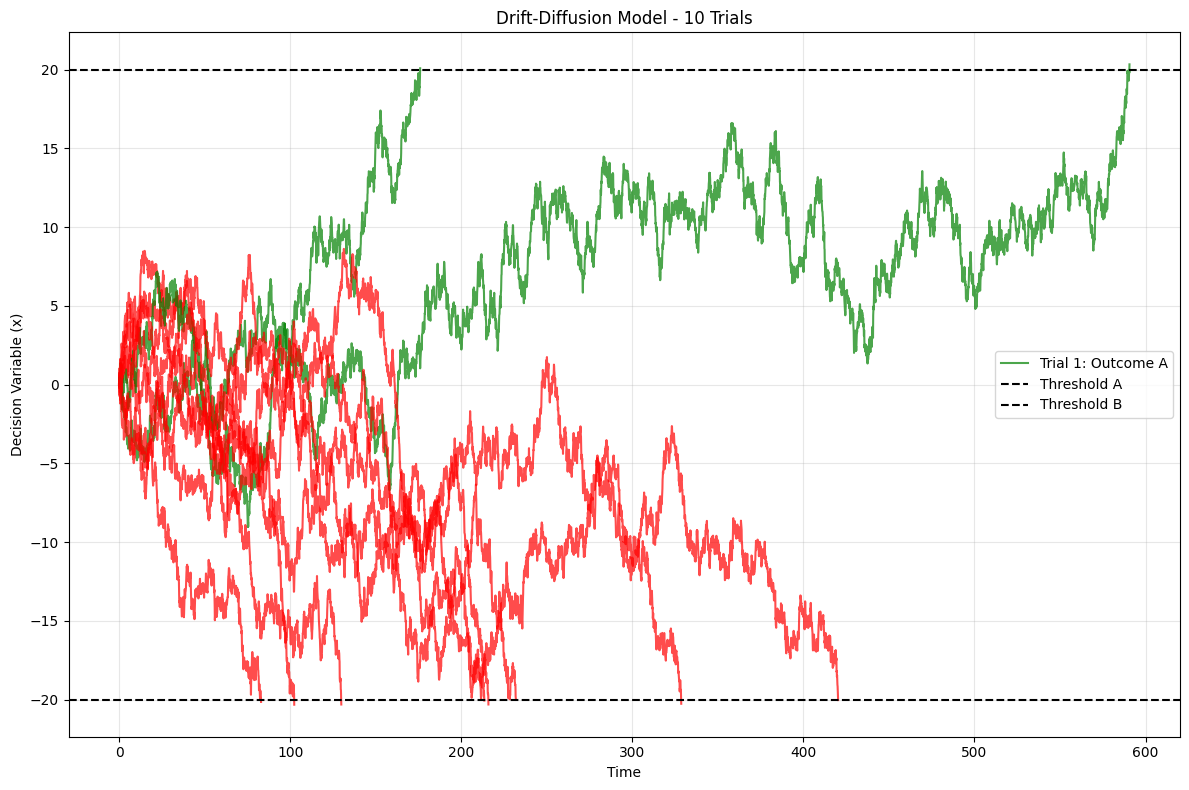

In [6]:

"""
Execute the simulation for Question 1.1:
Simulate the stochastic process for 10000 time steps with:
- dt = 0.1
- IA = 0.95
- IB = 1.0
- σ = 7.0
- µ = 20.0
- Starting from x0 = 0.0
- Run 10 trials
"""
print("Running simulation for Question 1.1...")

# Set seed for reproducibility
np.random.seed(42)

# Initialize the model with the specified parameters
model = DriftDiffusionModel(
    input_A=0.95,
    input_B=1.0,
    noise_magnitude=1.0,
    threshold=20.0,
    dt=0.1
)

# Simulate 10 trials
trial_results = model.simulate_multiple_trials(
    num_trials=10,
    initial_x=0.0,
    max_steps=10000
)

# Count the outcomes
outcomes = model.count_outcomes(trial_results)
print(f"Outcomes: {outcomes}")

# Get reaction times
reaction_times = model.get_reaction_times(trial_results)

# Calculate average reaction times for each outcome
avg_reaction_times = {}
for outcome, times in reaction_times.items():
    if times:
        avg_reaction_times[outcome] = sum(times) / len(times)

print(f"Average reaction times: {avg_reaction_times}")

# Plot the results

fig = plot_single_trials(
    trial_results, 
    title="Drift-Diffusion Model - 10 Trials",
    save_path="drift_diffusion_plot.png"
)

plt.show()




Running simulation for Question 1.2...
Outcomes for 1000 trials:
Decision A: 103 times
Decision B: 873 times
No decision: 24 times
Percentage of A: 10.30%
Percentage of B: 87.30%
Percentage of None: 2.40%
Figure saved to outcomes_1000_trials.png


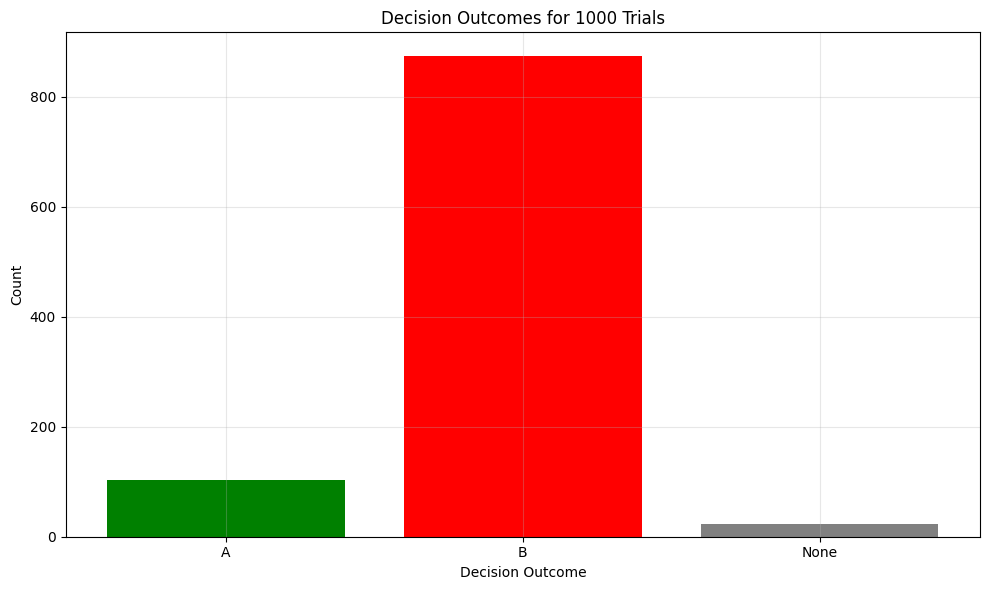

In [10]:


"""
Execute the simulation for Question 1.2:
Simulate the process 1000 times, starting from the same initial condition x0 = 0.
Store the outcomes: how many times decision A is taken? How many times decision B is taken?
How many times there is no decision?
"""
print("\nRunning simulation for Question 1.2...")

# Set seed for reproducibility
np.random.seed(42)

# Initialize the model with the specified parameters
model = DriftDiffusionModel(
    input_A=0.95,
    input_B=1.0,
    noise_magnitude=1.0,
    threshold=20.0,
    dt=0.1
)

# Simulate 1000 trials
trial_results = model.simulate_multiple_trials(
    num_trials=1000,
    initial_x=0.0,
    max_steps=10000
)

# Count the outcomes
outcomes = model.count_outcomes(trial_results)
print(f"Outcomes for 1000 trials:")
print(f"Decision A: {outcomes['A']} times")
print(f"Decision B: {outcomes['B']} times")
print(f"No decision: {outcomes['None']} times")

# Calculate percentages
total = sum(outcomes.values())
percentages = {outcome: count / total * 100 for outcome, count in outcomes.items()}
print(f"Percentage of A: {percentages['A']:.2f}%")
print(f"Percentage of B: {percentages['B']:.2f}%")
print(f"Percentage of None: {percentages['None']:.2f}%")

# Create a bar plot of the outcomes
plt.figure(figsize=(10, 6))
plt.bar(outcomes.keys(), outcomes.values(), color=['green', 'red', 'gray'])

plt.xlabel('Decision Outcome')
plt.ylabel('Count')
plt.title('Decision Outcomes for 1000 Trials')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outcomes_1000_trials.png")
print("Figure saved to outcomes_1000_trials.png")
plt.show()



Running simulation for Question 1.3...
Varying threshold (µ)...
Figure saved to threshold_variation.png


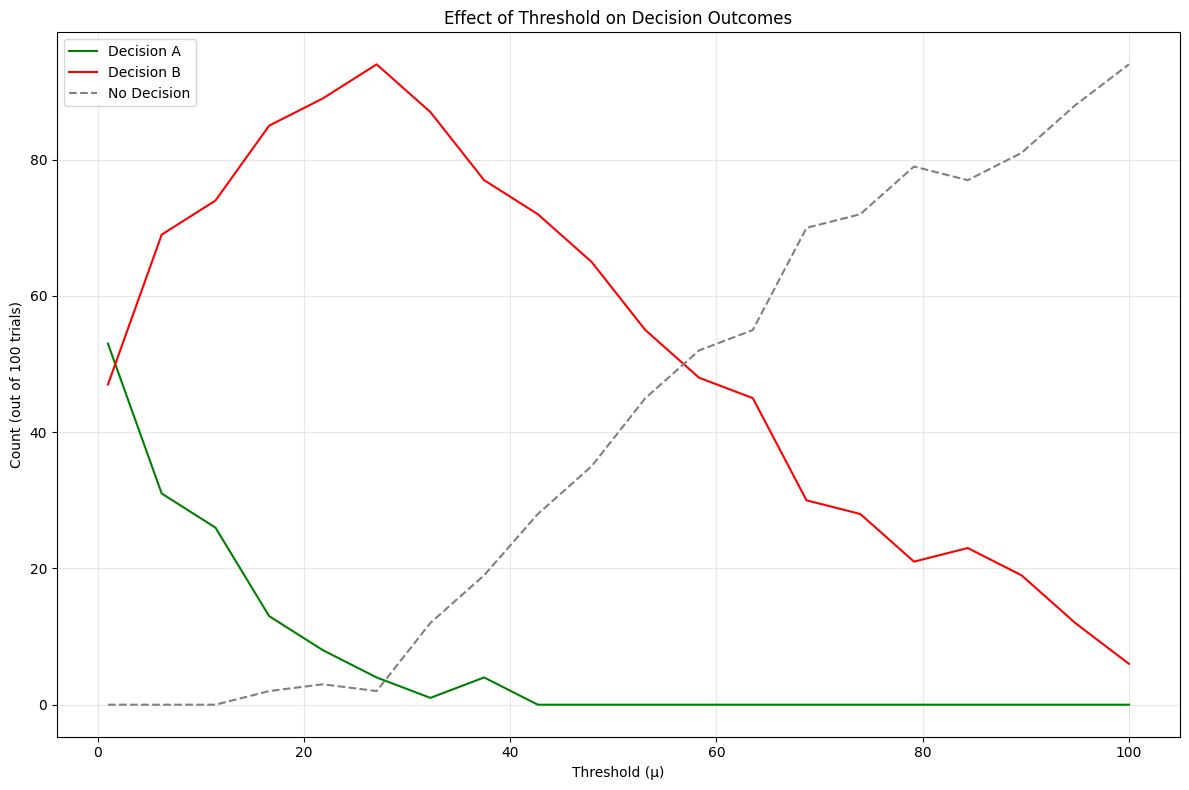

Varying evidence (E = IA - IB)...
Figure saved to evidence_variation.png


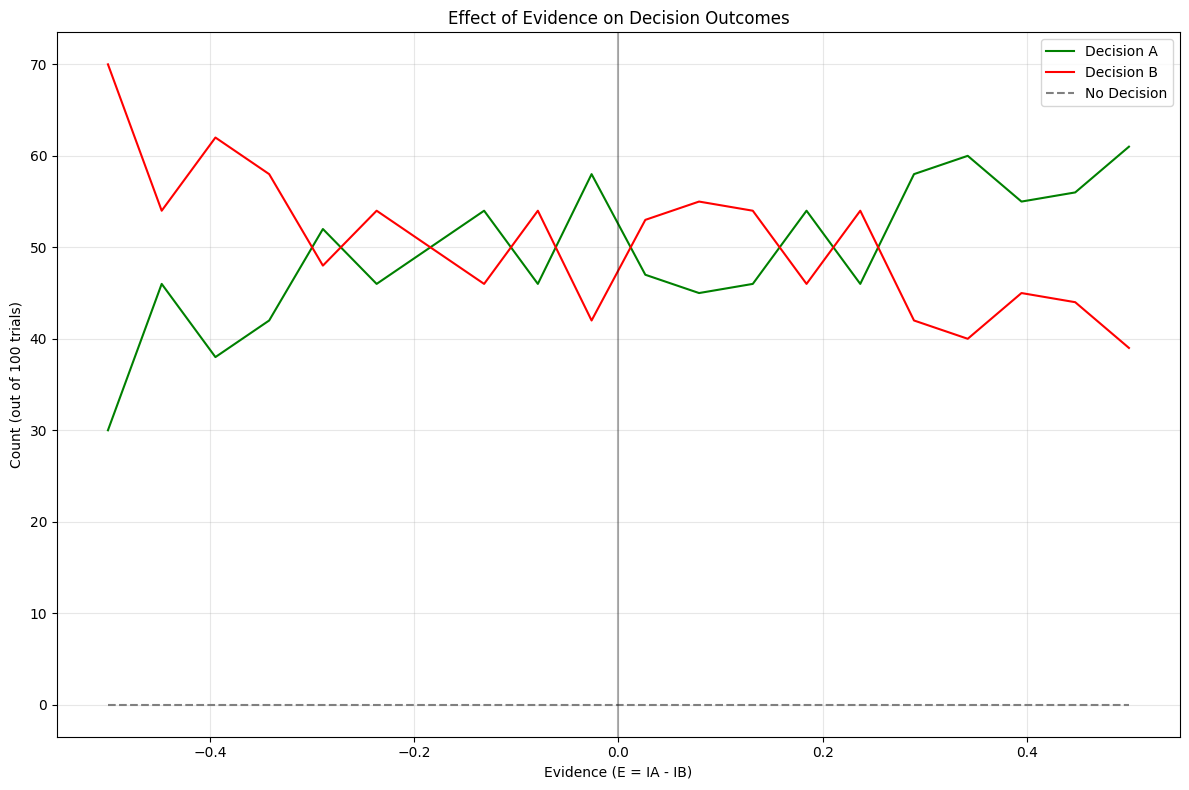

In [9]:

"""
Execute the simulation for Question 1.3:
Vary the parameters of the model and see how they affect the decision process.

Simulate the dynamics 100 times for each parameter value:
1. Vary threshold (µ) in (1, 100) with IA = 0.95, IB = 1 and σ = 7
2. Vary evidence (E = IA - IB) in (-0.5, 0.5) with σ = 7 and µ = 20

Plot the number of outcomes A and B as the parameter varies.
"""
print("\nRunning simulation for Question 1.3...")

# Set seed for reproducibility
np.random.seed(42)

# Vary threshold (µ)
print("Varying threshold (µ)...")
threshold_values = np.linspace(1, 100, 20)
threshold_outcomes_A = []
threshold_outcomes_B = []
threshold_outcomes_none = []

for threshold in threshold_values:
    model = DriftDiffusionModel(
        input_A=0.95,
        input_B=1.0,
        noise_magnitude=1.0,
        threshold=threshold,
        dt=0.1
    )
    
    # Simulate 100 trials for each threshold value
    trial_results = model.simulate_multiple_trials(
        num_trials=100,
        initial_x=0.0,
        max_steps=10000
    )
    
    # Count the outcomes
    outcomes = model.count_outcomes(trial_results)
    threshold_outcomes_A.append(outcomes['A'])
    threshold_outcomes_B.append(outcomes['B'])
    threshold_outcomes_none.append(outcomes['None'])

# Plot the results for varying threshold
plt.figure(figsize=(12, 8))
plt.plot(threshold_values, threshold_outcomes_A, 'g-', label='Decision A')
plt.plot(threshold_values, threshold_outcomes_B, 'r-', label='Decision B')
plt.plot(threshold_values, threshold_outcomes_none, 'gray', linestyle='--', label='No Decision')

plt.xlabel('Threshold (µ)')
plt.ylabel('Count (out of 100 trials)')
plt.title('Effect of Threshold on Decision Outcomes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("threshold_variation.png")
print("Figure saved to threshold_variation.png")
plt.show()

# Vary evidence (E = IA - IB)
print("Varying evidence (E = IA - IB)...")
evidence_values = np.linspace(-0.5, 0.5, 20)
evidence_outcomes_A = []
evidence_outcomes_B = []
evidence_outcomes_none = []

for evidence in evidence_values:
    model = DriftDiffusionModel(
        input_A=1.0 + evidence,  # Set IA to create the desired evidence level
        input_B=1.0,
        noise_magnitude=7.0,
        threshold=20.0,
        dt=0.1
    )
    
    # Simulate 100 trials for each evidence value
    trial_results = model.simulate_multiple_trials(
        num_trials=100,
        initial_x=0.0,
        max_steps=10000
    )
    
    # Count the outcomes
    outcomes = model.count_outcomes(trial_results)
    evidence_outcomes_A.append(outcomes['A'])
    evidence_outcomes_B.append(outcomes['B'])
    evidence_outcomes_none.append(outcomes['None'])

# Plot the results for varying evidence
plt.figure(figsize=(12, 8))
plt.plot(evidence_values, evidence_outcomes_A, 'g-', label='Decision A')
plt.plot(evidence_values, evidence_outcomes_B, 'r-', label='Decision B')
plt.plot(evidence_values, evidence_outcomes_none, 'gray', linestyle='--', label='No Decision')

plt.xlabel('Evidence (E = IA - IB)')
plt.ylabel('Count (out of 100 trials)')
plt.title('Effect of Evidence on Decision Outcomes')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("evidence_variation.png")
print("Figure saved to evidence_variation.png")
plt.show()



In [ ]:

def run_question_1_4():
    """
    Execute the simulation for Question 1.4:
    Reaction times distribution for different values of evidence:
    E = 0, E = 0.01, and E = 0.05
    
    Simulate the dynamics 1000 times for each evidence value and collect reaction times.
    Plot the reaction times distribution and explain the results.
    """
    print("\nRunning simulation for Question 1.4...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Different evidence values
    evidence_values = [0.0, 0.01, 0.05]
    reaction_times_by_evidence = {}
    reaction_times_by_outcome = {}
    
    for evidence in evidence_values:
        model = DriftDiffusionModel(
            input_A=1.0 + evidence,  # Set IA to create the desired evidence level
            input_B=1.0,
            noise_magnitude=7.0,
            threshold=20.0,
            dt=0.1
        )
        
        # Simulate 1000 trials for each evidence value
        trial_results = model.simulate_multiple_trials(
            num_trials=1000,
            initial_x=0.0,
            max_steps=10000
        )
        
        # Get reaction times
        reaction_times = model.get_reaction_times(trial_results)
        
        # Store all reaction times (combining A and B) for this evidence level
        all_times = reaction_times['A'] + reaction_times['B']
        reaction_times_by_evidence[evidence] = all_times
        
        # Store reaction times by outcome for this evidence level
        reaction_times_by_outcome[evidence] = reaction_times
        
        # Count outcomes
        outcomes = model.count_outcomes(trial_results)
        print(f"Evidence E = {evidence}:")
        print(f"Decision A: {outcomes['A']} times ({outcomes['A']/10:.1f}%)")
        print(f"Decision B: {outcomes['B']} times ({outcomes['B']/10:.1f}%)")
        print(f"No decision: {outcomes['None']} times ({outcomes['None']/10:.1f}%)")
        
        if all_times:
            print(f"Average reaction time: {sum(all_times) / len(all_times):.2f}")
        print()
    
    # Plot reaction time distributions
    plt.figure(figsize=(15, 10))
    
    for i, evidence in enumerate(evidence_values):
        plt.subplot(2, 2, i+1)
        
        if reaction_times_by_evidence[evidence]:
            plt.hist(reaction_times_by_evidence[evidence], bins=30, alpha=0.7, 
                     color='blue', edgecolor='black', density=True)
            plt.xlabel('Reaction Time')
            plt.ylabel('Probability Density')
            plt.title(f'Reaction Time Distribution (E = {evidence})')
            plt.grid(True, alpha=0.3)
    
    # Plot comparing all evidence values
    plt.subplot(2, 2, 4)
    colors = ['blue', 'green', 'red']
    
    for i, evidence in enumerate(evidence_values):
        if reaction_times_by_evidence[evidence]:
            plt.hist(reaction_times_by_evidence[evidence], bins=30, alpha=0.4, 
                     color=colors[i], edgecolor='black', density=True, 
                     label=f'E = {evidence}')
    
    plt.xlabel('Reaction Time')
    plt.ylabel('Probability Density')
    plt.title('Comparison of Reaction Time Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("reaction_time_distributions.png")
    print("Figure saved to reaction_time_distributions.png")
    plt.show()
    
    # Additional analysis: Reaction times by outcome for each evidence level
    plt.figure(figsize=(15, 10))
    
    for i, evidence in enumerate(evidence_values):
        plt.subplot(1, 3, i+1)
        
        # Plot reaction times for decision A
        if reaction_times_by_outcome[evidence]['A']:
            plt.hist(reaction_times_by_outcome[evidence]['A'], bins=20, alpha=0.6, 
                     color='green', edgecolor='black', density=True, label='Decision A')
        
        # Plot reaction times for decision B
        if reaction_times_by_outcome[evidence]['B']:
            plt.hist(reaction_times_by_outcome[evidence]['B'], bins=20, alpha=0.6, 
                     color='red', edgecolor='black', density=True, label='Decision B')
        
        plt.xlabel('Reaction Time')
        plt.ylabel('Probability Density')
        plt.title(f'Reaction Times by Outcome (E = {evidence})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("reaction_times_by_outcome.png")
    print("Figure saved to reaction_times_by_outcome.png")
    plt.show()


if __name__ == "__main__":
    # Uncomment the question you want to run
    # run_question_1_1()
    # run_question_1_2()
    run_question_1_3()
    # run_question_1_4()
    
    # Or run all questions
    # run_question_1_1()
    # run_question_1_2()
    # run_question_1_3()
    # run_question_1_4() 

In [ ]:

    def plot_single_trials(trial_results: List[Tuple[np.ndarray, np.ndarray, str]], title: str = "Multiple Trials", save_path: str = None):
        """
        Plot the decision variable trajectories for multiple trials.
        
        Parameters:
        -----------
        trial_results : List[Tuple[np.ndarray, np.ndarray, str]]
            The results from multiple trials
        title : str
            The title for the plot
        save_path : str
            If provided, save the figure to this path
        """
        plt.figure(figsize=(12, 8))
        
        for i, (time_points, x_values, outcome) in enumerate(trial_results):
            if outcome == 'A':
                plt.plot(time_points, x_values, label=f'Trial {i+1}: Outcome A' if i == 0 else None, color='green', alpha=0.7)
            elif outcome == 'B':
                plt.plot(time_points, x_values, label=f'Trial {i+1}: Outcome B' if i == 0 else None, color='red', alpha=0.7)
            else:
                plt.plot(time_points, x_values, label=f'Trial {i+1}: No Decision' if i == 0 else None, color='gray', alpha=0.7)
        
        # Plot thresholds
        plt.axhline(y=20, color='black', linestyle='--', label='Threshold A')
        plt.axhline(y=-20, color='black', linestyle='--', label='Threshold B')
        
        plt.xlabel('Time')
        plt.ylabel('Decision Variable (x)')
        plt.title(title)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            print(f"Figure saved to {save_path}")
            
        return plt.gcf()


def run_question_1_1():
    """
    Execute the simulation for Question 1.1:
    Simulate the stochastic process for 10000 time steps with:
    - dt = 0.1
    - IA = 0.95
    - IB = 1.0
    - σ = 7.0
    - µ = 20.0
    - Starting from x0 = 0.0
    - Run 10 trials
    """
    print("Running simulation for Question 1.1...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Initialize the model with the specified parameters
    model = DriftDiffusionModel(
        input_A=0.95,
        input_B=1.0,
        noise_magnitude=7.0,
        threshold=20.0,
        dt=0.1
    )
    
    # Simulate 10 trials
    trial_results = model.simulate_multiple_trials(
        num_trials=10,
        initial_x=0.0,
        max_steps=10000
    )
    
    # Count the outcomes
    outcomes = model.count_outcomes(trial_results)
    print(f"Outcomes: {outcomes}")
    
    # Get reaction times
    reaction_times = model.get_reaction_times(trial_results)
    
    # Calculate average reaction times for each outcome
    avg_reaction_times = {}
    for outcome, times in reaction_times.items():
        if times:
            avg_reaction_times[outcome] = sum(times) / len(times)
    
    print(f"Average reaction times: {avg_reaction_times}")
    
    # Plot the results
    plotter = ResultsPlotter()
    fig = plotter.plot_single_trials(
        trial_results, 
        title="Drift-Diffusion Model - 10 Trials",
        save_path="drift_diffusion_plot.png"
    )
    
    plt.show()


def run_question_1_2():
    """
    Execute the simulation for Question 1.2:
    Simulate the process 1000 times, starting from the same initial condition x0 = 0.
    Store the outcomes: how many times decision A is taken? How many times decision B is taken?
    How many times there is no decision?
    """
    print("\nRunning simulation for Question 1.2...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Initialize the model with the specified parameters
    model = DriftDiffusionModel(
        input_A=0.95,
        input_B=1.0,
        noise_magnitude=7.0,
        threshold=20.0,
        dt=0.1
    )
    
    # Simulate 1000 trials
    trial_results = model.simulate_multiple_trials(
        num_trials=1000,
        initial_x=0.0,
        max_steps=10000
    )
    
    # Count the outcomes
    outcomes = model.count_outcomes(trial_results)
    print(f"Outcomes for 1000 trials:")
    print(f"Decision A: {outcomes['A']} times")
    print(f"Decision B: {outcomes['B']} times")
    print(f"No decision: {outcomes['None']} times")
    
    # Calculate percentages
    total = sum(outcomes.values())
    percentages = {outcome: count / total * 100 for outcome, count in outcomes.items()}
    print(f"Percentage of A: {percentages['A']:.2f}%")
    print(f"Percentage of B: {percentages['B']:.2f}%")
    print(f"Percentage of None: {percentages['None']:.2f}%")
    
    # Create a bar plot of the outcomes
    plt.figure(figsize=(10, 6))
    plt.bar(outcomes.keys(), outcomes.values(), color=['green', 'red', 'gray'])
    
    plt.xlabel('Decision Outcome')
    plt.ylabel('Count')
    plt.title('Decision Outcomes for 1000 Trials')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("outcomes_1000_trials.png")
    print("Figure saved to outcomes_1000_trials.png")
    plt.show()


def run_question_1_3():
    """
    Execute the simulation for Question 1.3:
    Vary the parameters of the model and see how they affect the decision process.
    
    Simulate the dynamics 100 times for each parameter value:
    1. Vary threshold (µ) in (1, 100) with IA = 0.95, IB = 1 and σ = 7
    2. Vary evidence (E = IA - IB) in (-0.5, 0.5) with σ = 7 and µ = 20
    
    Plot the number of outcomes A and B as the parameter varies.
    """
    print("\nRunning simulation for Question 1.3...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Vary threshold (µ)
    print("Varying threshold (µ)...")
    threshold_values = np.linspace(1, 100, 20)
    threshold_outcomes_A = []
    threshold_outcomes_B = []
    threshold_outcomes_none = []
    
    for threshold in threshold_values:
        model = DriftDiffusionModel(
            input_A=0.95,
            input_B=1.0,
            noise_magnitude=7.0,
            threshold=threshold,
            dt=0.1
        )
        
        # Simulate 100 trials for each threshold value
        trial_results = model.simulate_multiple_trials(
            num_trials=100,
            initial_x=0.0,
            max_steps=10000
        )
        
        # Count the outcomes
        outcomes = model.count_outcomes(trial_results)
        threshold_outcomes_A.append(outcomes['A'])
        threshold_outcomes_B.append(outcomes['B'])
        threshold_outcomes_none.append(outcomes['None'])
    
    # Plot the results for varying threshold
    plt.figure(figsize=(12, 8))
    plt.plot(threshold_values, threshold_outcomes_A, 'g-', label='Decision A')
    plt.plot(threshold_values, threshold_outcomes_B, 'r-', label='Decision B')
    plt.plot(threshold_values, threshold_outcomes_none, 'gray', linestyle='--', label='No Decision')
    
    plt.xlabel('Threshold (µ)')
    plt.ylabel('Count (out of 100 trials)')
    plt.title('Effect of Threshold on Decision Outcomes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("threshold_variation.png")
    print("Figure saved to threshold_variation.png")
    plt.show()
    
    # Vary evidence (E = IA - IB)
    print("Varying evidence (E = IA - IB)...")
    evidence_values = np.linspace(-0.5, 0.5, 20)
    evidence_outcomes_A = []
    evidence_outcomes_B = []
    evidence_outcomes_none = []
    
    for evidence in evidence_values:
        model = DriftDiffusionModel(
            input_A=1.0 + evidence,  # Set IA to create the desired evidence level
            input_B=1.0,
            noise_magnitude=7.0,
            threshold=20.0,
            dt=0.1
        )
        
        # Simulate 100 trials for each evidence value
        trial_results = model.simulate_multiple_trials(
            num_trials=100,
            initial_x=0.0,
            max_steps=10000
        )
        
        # Count the outcomes
        outcomes = model.count_outcomes(trial_results)
        evidence_outcomes_A.append(outcomes['A'])
        evidence_outcomes_B.append(outcomes['B'])
        evidence_outcomes_none.append(outcomes['None'])
    
    # Plot the results for varying evidence
    plt.figure(figsize=(12, 8))
    plt.plot(evidence_values, evidence_outcomes_A, 'g-', label='Decision A')
    plt.plot(evidence_values, evidence_outcomes_B, 'r-', label='Decision B')
    plt.plot(evidence_values, evidence_outcomes_none, 'gray', linestyle='--', label='No Decision')
    
    plt.xlabel('Evidence (E = IA - IB)')
    plt.ylabel('Count (out of 100 trials)')
    plt.title('Effect of Evidence on Decision Outcomes')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("evidence_variation.png")
    print("Figure saved to evidence_variation.png")
    plt.show()


def run_question_1_4():
    """
    Execute the simulation for Question 1.4:
    Reaction times distribution for different values of evidence:
    E = 0, E = 0.01, and E = 0.05
    
    Simulate the dynamics 1000 times for each evidence value and collect reaction times.
    Plot the reaction times distribution and explain the results.
    """
    print("\nRunning simulation for Question 1.4...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Different evidence values
    evidence_values = [0.0, 0.01, 0.05]
    reaction_times_by_evidence = {}
    reaction_times_by_outcome = {}
    
    for evidence in evidence_values:
        model = DriftDiffusionModel(
            input_A=1.0 + evidence,  # Set IA to create the desired evidence level
            input_B=1.0,
            noise_magnitude=7.0,
            threshold=20.0,
            dt=0.1
        )
        
        # Simulate 1000 trials for each evidence value
        trial_results = model.simulate_multiple_trials(
            num_trials=1000,
            initial_x=0.0,
            max_steps=10000
        )
        
        # Get reaction times
        reaction_times = model.get_reaction_times(trial_results)
        
        # Store all reaction times (combining A and B) for this evidence level
        all_times = reaction_times['A'] + reaction_times['B']
        reaction_times_by_evidence[evidence] = all_times
        
        # Store reaction times by outcome for this evidence level
        reaction_times_by_outcome[evidence] = reaction_times
        
        # Count outcomes
        outcomes = model.count_outcomes(trial_results)
        print(f"Evidence E = {evidence}:")
        print(f"Decision A: {outcomes['A']} times ({outcomes['A']/10:.1f}%)")
        print(f"Decision B: {outcomes['B']} times ({outcomes['B']/10:.1f}%)")
        print(f"No decision: {outcomes['None']} times ({outcomes['None']/10:.1f}%)")
        
        if all_times:
            print(f"Average reaction time: {sum(all_times) / len(all_times):.2f}")
        print()
    
    # Plot reaction time distributions
    plt.figure(figsize=(15, 10))
    
    for i, evidence in enumerate(evidence_values):
        plt.subplot(2, 2, i+1)
        
        if reaction_times_by_evidence[evidence]:
            plt.hist(reaction_times_by_evidence[evidence], bins=30, alpha=0.7, 
                     color='blue', edgecolor='black', density=True)
            plt.xlabel('Reaction Time')
            plt.ylabel('Probability Density')
            plt.title(f'Reaction Time Distribution (E = {evidence})')
            plt.grid(True, alpha=0.3)
    
    # Plot comparing all evidence values
    plt.subplot(2, 2, 4)
    colors = ['blue', 'green', 'red']
    
    for i, evidence in enumerate(evidence_values):
        if reaction_times_by_evidence[evidence]:
            plt.hist(reaction_times_by_evidence[evidence], bins=30, alpha=0.4, 
                     color=colors[i], edgecolor='black', density=True, 
                     label=f'E = {evidence}')
    
    plt.xlabel('Reaction Time')
    plt.ylabel('Probability Density')
    plt.title('Comparison of Reaction Time Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("reaction_time_distributions.png")
    print("Figure saved to reaction_time_distributions.png")
    plt.show()
    
    # Additional analysis: Reaction times by outcome for each evidence level
    plt.figure(figsize=(15, 10))
    
    for i, evidence in enumerate(evidence_values):
        plt.subplot(1, 3, i+1)
        
        # Plot reaction times for decision A
        if reaction_times_by_outcome[evidence]['A']:
            plt.hist(reaction_times_by_outcome[evidence]['A'], bins=20, alpha=0.6, 
                     color='green', edgecolor='black', density=True, label='Decision A')
        
        # Plot reaction times for decision B
        if reaction_times_by_outcome[evidence]['B']:
            plt.hist(reaction_times_by_outcome[evidence]['B'], bins=20, alpha=0.6, 
                     color='red', edgecolor='black', density=True, label='Decision B')
        
        plt.xlabel('Reaction Time')
        plt.ylabel('Probability Density')
        plt.title(f'Reaction Times by Outcome (E = {evidence})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("reaction_times_by_outcome.png")
    print("Figure saved to reaction_times_by_outcome.png")
    plt.show()


if __name__ == "__main__":
    # Uncomment the question you want to run
    # run_question_1_1()
    # run_question_1_2()
    run_question_1_3()
    # run_question_1_4()
    
    # Or run all questions
    # run_question_1_1()
    # run_question_1_2()
    # run_question_1_3()
    # run_question_1_4() 